In [1]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: xgboost_test
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, CanonSmiles, Draw, MolFromSmiles, PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import DataStructs
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import useful_rdkit_utils as uru

import prolif as plf

import safe as sf
import datamol as dm

import mols2grid

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, roc_auc_score, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
pdb = '2zdt'

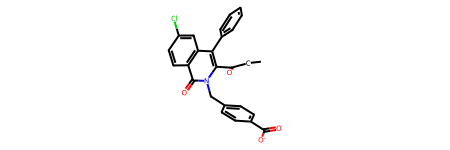

In [4]:
initial_mol = Chem.MolFromMolFile(f"data/docking/{pdb}_ligand.sdf")
initial = Chem.MolToSmiles(initial_mol)

initial_mol

In [5]:
initial

'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(=O)[O-])cc1'

In [6]:
REF_MOL_FILEPATH = f"data/docking/{pdb}_ligand.sdf"
PDB_FILEPATH = f"data/docking/{pdb}.pdb"

fp = plf.Fingerprint()

mol = Chem.MolFromPDBFile(PDB_FILEPATH, removeHs=False)
prot = plf.Molecule(mol)
suppl = plf.sdf_supplier(REF_MOL_FILEPATH)
fp.run_from_iterable(suppl, prot, progress=True)
df_ifp = fp.to_dataframe()
df_ifp.columns = df_ifp.columns.droplevel(0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df_ifp

protein        LYS68.A                        ILE70.A    GLY71.A     VAL78.A  \
interaction HBAcceptor Anionic VdWContact Hydrophobic VdWContact Hydrophobic   
Frame                                                                          
0                 True    True       True        True       True        True   

protein                    ALA91.A               ILE124.A  ...   ASN152.A  \
interaction VdWContact Hydrophobic VdWContact Hydrophobic  ... VdWContact   
Frame                                                      ...              
0                 True        True       True        True  ...       True   

protein       SER193.A    VAL196.A               LEU206.A    46C901.A  \
interaction VdWContact Hydrophobic VdWContact Hydrophobic Hydrophobic   
Frame                                                                   
0                 True        True       True        True        True   

protein                             HOH986.A             
interaction PiStacking VdWContact HBAcceptor VdWContact  
Frame                                                    
0                 True       True       True       True  

[1 rows x 28 columns]

In [8]:
def mcs_rmsd(mol_1, mol_2):
    mcs_res = FindMCS([mol_1, mol_2])
    pat = Chem.MolFromSmarts(mcs_res.smartsString)
    match_1 = mol_1.GetSubstructMatches(pat)
    match_2 = mol_2.GetSubstructMatches(pat)
    min_rmsd = 1e6
    for m1 in match_1:
        for m2 in match_2:
            crd_1 = mol_1.GetConformer(0).GetPositions()[list(m1)]
            crd_2 = mol_2.GetConformer(0).GetPositions()[list(m2)]
            rmsd = np.sqrt((((crd_1 - crd_2)**2).sum()).mean())
            min_rmsd = min(min_rmsd, rmsd)
    return min_rmsd

In [9]:
def compute_features(df, ifp):

    cols = ifp.columns

    num_cols = len(ifp.columns)

    data = {'mol_id' : [],
            'num_interactions' : [],
            'weighted_interactions' : [],
            'num_VdW' : [],
            'num_hydrophobic' : [],
            'num_HBAcceptor' : [],
            'num_ionic' : []}

    for index, row in ifp.iterrows():

        weighted_interactions = 0
        num_VdW = 0
        num_hydrophobic = 0
        num_HBAcceptor = 0
        num_ionic = 0
        
        data['mol_id'].append(row['ID'][0])
        data['num_interactions'].append(row[:-1].sum())

        for value in cols:
            
            if value[1] == 'VdWContact':
                weighted_interactions += 1 * row[value]
                num_VdW += 1 * row[value]
            elif value[1] == 'Hydrophobic':
                weighted_interactions += 2 * row[value]
                num_hydrophobic += 1 * row[value]
            elif value[1] == 'HBAcceptor':
                weighted_interactions += 3 * row[value]
                num_HBAcceptor += 1 * row[value]
            elif value[1] == 'Anionic' or value[1] == 'Cationic':
                weighted_interactions += 4 * row[value]
                num_ionic += 1 * row[value]

        data['weighted_interactions'].append(weighted_interactions)
        data['num_VdW'].append(num_VdW)
        data['num_hydrophobic'].append(num_hydrophobic)
        data['num_HBAcceptor'].append(num_HBAcceptor)
        data['num_ionic'].append(num_ionic)

            

    features = pd.DataFrame(data)

    df = df.merge(features[['mol_id', 'num_interactions', 'weighted_interactions', 'num_VdW', 'num_hydrophobic', 'num_HBAcceptor', 'num_ionic']], left_on='ID', right_on='mol_id', how='left')

    df = df.drop(['mol_id'], axis=1).sort_values(['Docking score'], ascending=True)

    df.dropna(axis=0, subset=['Docking score'], inplace=True)
    df['num_interactions'].fillna(0, inplace=True)
    df['weighted_interactions'].fillna(0, inplace=True)

    return df

In [10]:
def visualize_fingerprint(ifp):

    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.heatmap(ifp,cmap=sns.cm.rocket_r)
    ax.set_ylabel("Molecule")
    ax.set_xlabel("Protein Interaction")

    return ax

## Reinvent

In [11]:
model = 'reinvent'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [12]:
model = 'reinvent'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_reinvent = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_reinvent = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [13]:
df_reinvent = compute_features(df_reinvent, ifp_reinvent)

In [14]:
df_reinvent

,SMILES,Input_SMILES,Tanimoto,Prior,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.619469,scaffold,MOL0121,-16.624857,3.737471,27,45,13,10,4,0
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.688679,scaffold,MOL0196,-16.540930,3.676144,32,48,17,11,3,0
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.830000,high_similarity,MOL0150,-16.529593,5.569642,25,40,11,10,3,0
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.535088,scaffold,MOL0099,-16.301600,3.785833,29,45,16,10,3,0
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.678899,scaffold,MOL0127,-16.295380,5.360354,27,42,14,11,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,CCC(=O)c1c(-c2ccc(S(C)(=O)=O)cc2)c2cc(Cl)ccc2c...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.628319,scaffold_generic,MOL0074,-11.602587,9.200715,31,47,16,11,3,0
46,CCOc1ccc2c(C(=O)CC)n(Cc3ccc(C(=O)O)cc3)c(=O)c(...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.636364,scaffold,MOL0046,-10.755634,9.745061,31,47,17,12,2,0
27,CCCCNS(=O)(=O)COc1ccc(Cn2c(C(=O)CC)c(-c3ccccc3...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.613445,mmp,MOL0027,-10.040281,8.536440,30,45,15,12,2,0
90,COc1ccc2c(C(=O)OC(C)C)n(Cc3ccc(C(=O)O)cc3)c(=O...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.637168,scaffold,MOL0090,-9.814790,8.372586,30,40,19,9,1,0


In [15]:
df_reinvent.drop(['Input_SMILES', 'Prior', 'Tanimoto'], axis=1, inplace=True)
df_reinvent['Model'] = model

In [16]:
df_reinvent

,SMILES,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,Model
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,MOL0121,-16.624857,3.737471,27,45,13,10,4,0,reinvent
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,MOL0196,-16.540930,3.676144,32,48,17,11,3,0,reinvent
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,MOL0150,-16.529593,5.569642,25,40,11,10,3,0,reinvent
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,MOL0099,-16.301600,3.785833,29,45,16,10,3,0,reinvent
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,MOL0127,-16.295380,5.360354,27,42,14,11,2,0,reinvent
...,...,...,...,...,...,...,...,...,...,...,...
74,CCC(=O)c1c(-c2ccc(S(C)(=O)=O)cc2)c2cc(Cl)ccc2c...,MOL0074,-11.602587,9.200715,31,47,16,11,3,0,reinvent
46,CCOc1ccc2c(C(=O)CC)n(Cc3ccc(C(=O)O)cc3)c(=O)c(...,MOL0046,-10.755634,9.745061,31,47,17,12,2,0,reinvent
27,CCCCNS(=O)(=O)COc1ccc(Cn2c(C(=O)CC)c(-c3ccccc3...,MOL0027,-10.040281,8.536440,30,45,15,12,2,0,reinvent
90,COc1ccc2c(C(=O)OC(C)C)n(Cc3ccc(C(=O)O)cc3)c(=O...,MOL0090,-9.814790,8.372586,30,40,19,9,1,0,reinvent


### CReM

In [17]:
model = 'crem'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [18]:
model = 'crem'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_crem = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_crem = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [19]:
df_crem = compute_features(df_crem, ifp_crem)

In [20]:
model_df = pd.concat((df_reinvent, df_crem))

### Coati

In [21]:
model = 'coati'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [22]:
model = 'coati'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_coati = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_coati = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [23]:
df_coati = compute_features(df_coati, ifp_coati)

In [24]:
model_df = pd.concat((model_df, df_coati))

### SAFE

In [25]:
model = 'safe'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [26]:
model = 'safe'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_safe = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_safe = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [27]:
df_safe = compute_features(df_safe, ifp_safe)

In [28]:
df_safe

,SMILES,Model,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic
48,CS(=O)(=O)c1cc(-c2cccc(OCc3cccnc3)n2)ccc1F,safe,MOL0048,-11.894488,16.457680,22.0,33.0,12.0,9.0,1.0,0.0
141,O=C(C[C@@H]1CCC2(CCC2)O1)Nc1c(F)cccc1N1CCCCC1,safe,MOL0141,-11.844474,27.467486,21.0,32.0,11.0,9.0,1.0,0.0
64,CC[C@H](C)n1nc(C(=O)NCc2cc([N+](=O)[O-])ccc2OC...,safe,MOL0064,-11.763090,5.480089,23.0,40.0,11.0,9.0,1.0,2.0
183,C[C@@H]1C[C@H](Nc2cccc(C(N)=O)c2)C[NH+]1C1CC1,safe,MOL0183,-11.299672,22.876992,16.0,21.0,7.0,7.0,0.0,0.0
62,O=C(N[C@@H]1CCCN(C(=O)[C@@H]2C[C@@H]3CCCC[C@@H...,safe,MOL0062,-10.686996,17.605077,26.0,37.0,16.0,9.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1,CO[C@]1(C)C[C@H]([NH2+]CC(=O)NC2CC[NH+](Cc3ccc...,safe,MOL0001,-4.748751,24.153877,26.0,34.0,16.0,9.0,0.0,0.0
35,NCCCCOCF,safe,MOL0035,-4.662041,10.871446,12.0,18.0,7.0,4.0,1.0,0.0
194,CC1CCN(Cc2cccc(N=C(O)N3CCN(Cc4cscn4)CC3)c2)CC1,safe,MOL0194,-4.621443,24.408861,22.0,29.0,15.0,7.0,0.0,0.0
20,COc1ccc(C(=O)N2C[C@H]3COC[C@@H](C2)[C@H]3NC(=O...,safe,MOL0020,-4.489938,14.896661,28.0,38.0,19.0,8.0,1.0,0.0


In [29]:
model_df = pd.concat((model_df, df_safe))

In [30]:
model_df.head()

,SMILES,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,Model
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,MOL0121,-16.624857,3.737471,27.0,45.0,13.0,10.0,4.0,0.0,reinvent
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,MOL0196,-16.540930,3.676144,32.0,48.0,17.0,11.0,3.0,0.0,reinvent
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,MOL0150,-16.529593,5.569642,25.0,40.0,11.0,10.0,3.0,0.0,reinvent
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,MOL0099,-16.301600,3.785833,29.0,45.0,16.0,10.0,3.0,0.0,reinvent
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,MOL0127,-16.295380,5.360354,27.0,42.0,14.0,11.0,2.0,0.0,reinvent


In [31]:
smiles = model_df['SMILES'].to_list()

In [32]:
y = model_df['Model'].to_numpy().reshape(-1, 1)

### Evaluating Metrics w/ MolScore

In [33]:
from molscore import MolScore

In [34]:
ms = MolScore(model_name='mol2mol', task_config='molscore/feature_selection.json')
scores = ms.score(smiles)

Found existing directory, appending current time to distinguish


Found existing rascore-env
Launching server: conda run -n rascore-env python /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/scoring_functions/servers/rascore_server.py --port 8018 --model_path /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/data/models/RAScore/XGB_chembl_ecfp_counts/model.pkl


In [35]:
# Once finished
metrics = ms.compute_metrics(
    endpoints=None, # Optional list: by default will use the running final score/reward value
    thresholds=None,  # Optional list: if specified will calculate the yield of molecules above that threshold 
    # chemistry_filters_basic=False,  # Optional, bool: Additionally re-calculate metrics after filtering out unreasonable chemistry
    budget=10000,  # Optional, int: Calculate metrics only with molecules within this budget
    n_jobs=1,  # Optional, int: Multiprocessing
    benchmark=None,  # Optional, str: Name of benchmark, this may specify additional metrics to compute
)

In [95]:
df = pd.read_csv('molscore/2024_07_18_mol2mol_feature_selection_23_45_13/iterations/000001_scores.csv', index_col=0)

In [96]:
df

,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,...,desc_FlourineCount,tanimoto_Sim,tanimoto_Cmpd1_Sim,dice_Sim,dice_Cmpd1_Sim,RAScore_pred_proba,raw_valid_score,amean,filter,score_time
0,mol2mol,feature_selection,1,0,3.01106,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,True,1,True,0,...,3,0.514286,0.514286,0.679245,0.679245,0.982867,1,1.0,1.0,8.274611
1,mol2mol,feature_selection,1,1,3.01106,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,True,1,True,0,...,0,0.521127,0.521127,0.685185,0.685185,0.948534,1,1.0,1.0,8.274611
2,mol2mol,feature_selection,1,2,3.01106,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,True,1,True,0,...,0,0.733333,0.733333,0.846154,0.846154,0.910709,1,1.0,1.0,8.274611
3,mol2mol,feature_selection,1,3,3.01106,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,True,1,True,0,...,0,0.438356,0.438356,0.609524,0.609524,0.945486,1,1.0,1.0,8.274611
4,mol2mol,feature_selection,1,4,3.01106,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,True,1,True,0,...,3,0.522388,0.522388,0.686275,0.686275,0.957991,1,1.0,1.0,8.274611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,mol2mol,feature_selection,1,789,3.01106,CO[C@]1(C)C[C@H]([NH2+]CC(=O)NC2CC[NH+](Cc3ccc...,True,1,True,0,...,0,0.129032,0.129032,0.228571,0.228571,0.848671,1,1.0,1.0,8.274611
790,mol2mol,feature_selection,1,790,3.01106,NCCCCOCF,True,1,True,0,...,1,0.014925,0.014925,0.029412,0.029412,0.985933,1,1.0,1.0,8.274611
791,mol2mol,feature_selection,1,791,3.01106,CC1CCN(Cc2cccc(N=C(O)N3CCN(Cc4cscn4)CC3)c2)CC1,True,1,True,0,...,0,0.142857,0.142857,0.250000,0.250000,0.952894,1,1.0,1.0,8.274611
792,mol2mol,feature_selection,1,792,3.01106,COc1ccc(C(=O)N2C[C@H]3COC[C@@H](C2)[C@H]3NC(=O...,True,1,True,0,...,0,0.116505,0.116505,0.208696,0.208696,0.634255,1,1.0,1.0,8.274611


In [97]:
df.drop(['desc_MolecularFormula', 'dice_Cmpd1_Sim', 'tanimoto_Cmpd1_Sim', 'desc_SAscore', 'desc_PenLogP'], axis=1, inplace=True)

In [98]:
X = df.iloc[:, 10:-4]

Adding new features

In [99]:
X['Docking score'] = model_df['Docking score'].values
X['num_interactions'] = model_df['num_interactions'].values
X['weighted_interactions'] = model_df['weighted_interactions'].values
X['num_VdW'] = model_df['num_VdW'].values
X['num_hydophobic'] = model_df['num_hydrophobic'].values
X['num_HBAcceptor'] = model_df['num_HBAcceptor'].values
X['num_ionic'] = model_df['num_ionic'].values
X['CLogP * num_interactions'] = df['desc_CLogP'] * X['num_interactions']
X['CLogP * weighted_interactions'] = df['desc_CLogP'] * X['weighted_interactions']
X['rmsd'] = model_df['rmsd'].values

In [100]:
X.head()

,desc_QED,desc_CLogP,desc_MolWt,desc_HeavyAtomCount,desc_HeavyAtomMolWt,desc_NumHAcceptors,desc_NumHDonors,desc_NumHeteroatoms,desc_NumRotatableBonds,desc_NumAromaticRings,...,Docking score,num_interactions,weighted_interactions,num_VdW,num_hydophobic,num_HBAcceptor,num_ionic,CLogP * num_interactions,CLogP * weighted_interactions,rmsd
0,0.351621,5.6105,495.453,36,475.293,5,1,9,6,4,...,-16.624857,27.0,45.0,13.0,10.0,4.0,0.0,151.4835,252.4725,3.737471
1,0.340885,5.2971,487.939,35,465.763,5,1,7,8,4,...,-16.540930,32.0,48.0,17.0,11.0,3.0,0.0,169.5072,254.2608,3.676144
2,0.271819,5.7495,459.929,33,437.753,5,0,6,6,4,...,-16.529593,25.0,40.0,11.0,10.0,3.0,0.0,143.7375,229.9800,5.569642
3,0.397044,4.5214,455.466,34,434.298,5,2,7,7,4,...,-16.301600,29.0,45.0,16.0,10.0,3.0,0.0,131.1206,203.4630,3.785833
4,0.387424,5.6364,465.427,34,447.283,4,1,8,5,4,...,-16.295380,27.0,42.0,14.0,11.0,2.0,0.0,152.1828,236.7288,5.360354


#### Exploratory Data Analysis:

* Normalizing columns
* Evaluating correlations between features

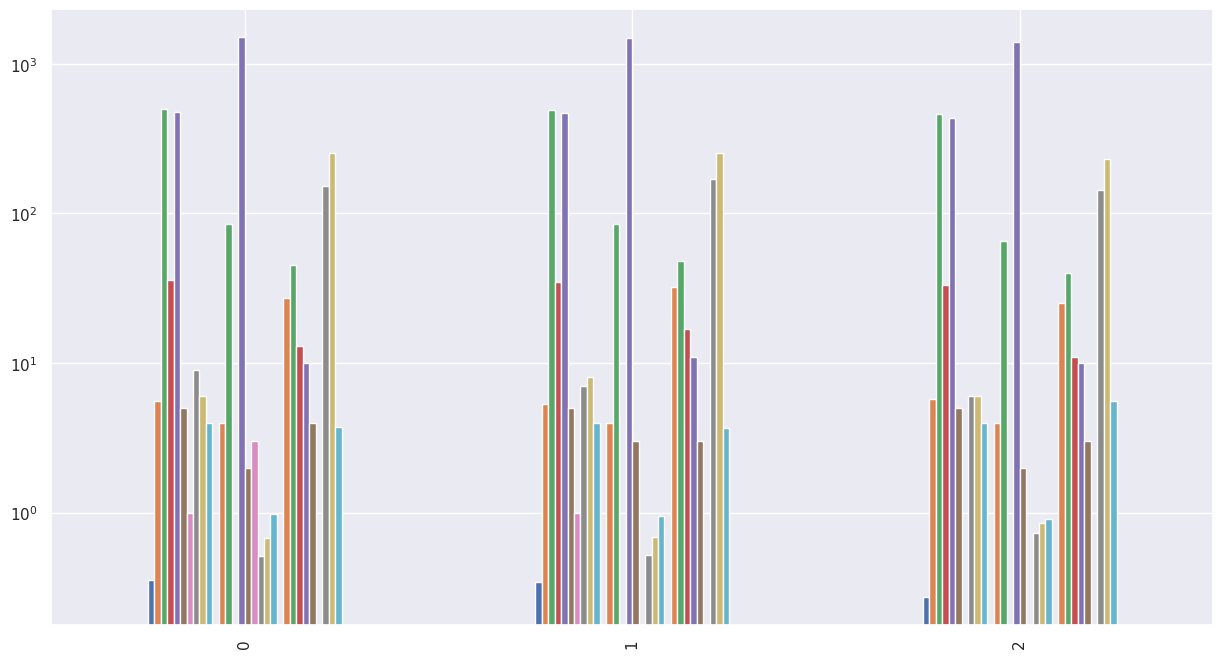

In [101]:
X[:3].plot(kind='bar', legend=False, logy=True);

In [102]:
X_normalized = X.copy()

# Normalizing each column using min-max scaler
for column in X.columns:
   
   X_normalized[column] = (X_normalized[column] - X_normalized[column].min()) / (X_normalized[column].max() - X_normalized[column].min())     

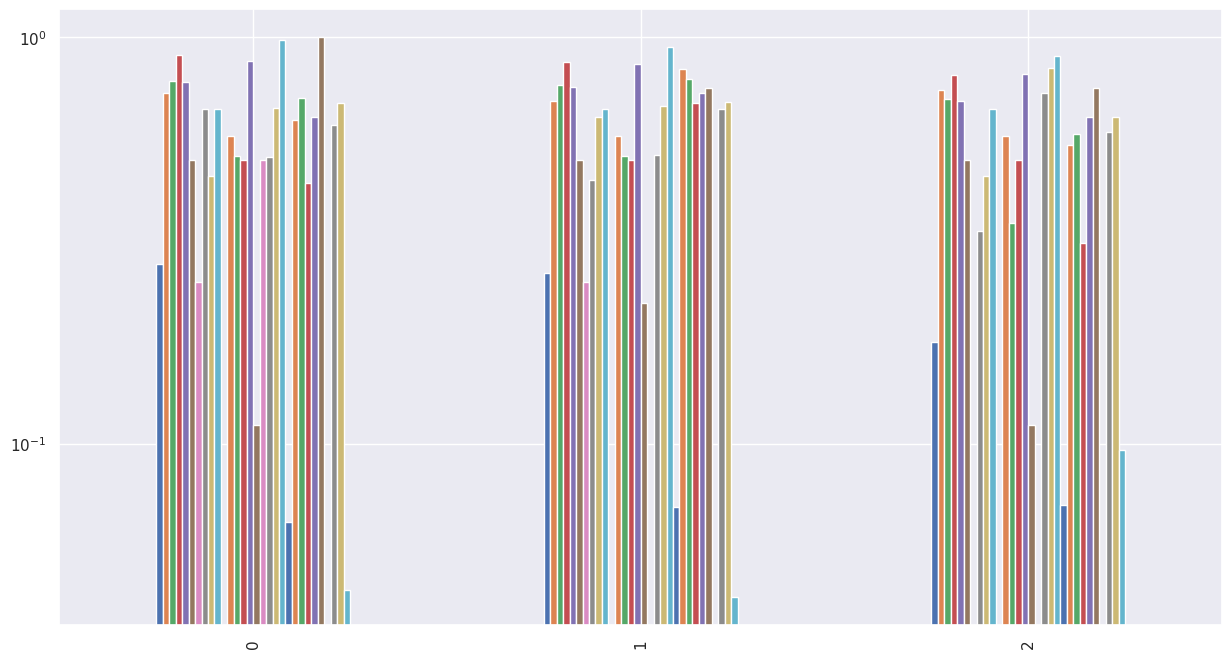

In [103]:
X_normalized[:3].plot(kind='bar', legend=False, logy=True);

In [104]:
enc = OrdinalEncoder()

ord = enc.fit_transform(y)

In [45]:
X['Model'] = ord.squeeze()

In [46]:
X.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,desc_QED,desc_CLogP,desc_MolWt,desc_HeavyAtomCount,desc_HeavyAtomMolWt,desc_NumHAcceptors,desc_NumHDonors,desc_NumHeteroatoms,desc_NumRotatableBonds,desc_NumAromaticRings,desc_NumAliphaticRings,desc_RingCount,desc_TPSA,desc_FormalCharge,desc_Bertz,desc_MaxConsecutiveRotatableBonds,desc_FlourineCount,tanimoto_Sim,dice_Sim,RAScore_pred_proba,Docking score,num_interactions,weighted_interactions,num_VdW,num_hydophobic,num_HBAcceptor,num_ionic,CLogP * num_interactions,CLogP * weighted_interactions,rmsd,Model
desc_QED,1.000000,-0.711097,-0.777732,-0.787451,-0.783157,-0.284822,0.295250,-0.079967,-0.590263,-0.788682,0.566248,-0.628429,-0.061724,0.134665,-0.825621,0.016030,0.126892,-0.787413,-0.800812,0.119843,0.667072,-0.421024,-0.524104,-0.051275,-0.614820,-0.373239,0.043816,-0.746814,-0.765139,0.448468,0.513979
desc_CLogP,-0.711097,1.000000,0.641076,0.632231,0.648549,-0.062776,-0.383797,-0.180323,0.326853,0.740861,-0.534838,0.587541,-0.326236,-0.102217,0.705280,-0.180810,-0.009246,0.705615,0.718509,-0.011326,-0.646546,0.308582,0.402139,-0.028669,0.551384,0.302544,-0.122447,0.960005,0.952995,-0.441974,-0.380675
desc_MolWt,-0.777732,0.641076,1.000000,0.956188,0.997581,0.460006,-0.249858,0.388086,0.597146,0.746004,-0.366128,0.755645,0.267662,-0.149282,0.890128,-0.116743,-0.060487,0.695916,0.722999,-0.255025,-0.600314,0.445780,0.544195,0.082503,0.580569,0.406738,-0.003601,0.682803,0.698918,-0.422438,-0.420435
desc_HeavyAtomCount,-0.787451,0.632231,0.956188,1.000000,0.949550,0.476774,-0.278649,0.305467,0.628928,0.787272,-0.368976,0.814003,0.289179,-0.194201,0.924250,-0.119695,-0.093887,0.722184,0.753738,-0.239248,-0.611000,0.463383,0.568717,0.100995,0.581835,0.421398,0.030177,0.676483,0.695061,-0.408447,-0.475679
desc_HeavyAtomMolWt,-0.783157,0.648549,0.997581,0.949550,1.000000,0.468736,-0.275431,0.394546,0.573574,0.769641,-0.399910,0.758487,0.277904,-0.183151,0.904586,-0.136658,-0.048276,0.709362,0.738159,-0.236432,-0.613789,0.454182,0.558056,0.083802,0.585448,0.418774,0.013496,0.691318,0.708424,-0.422744,-0.446734
desc_NumHAcceptors,-0.284822,-0.062776,0.460006,0.476774,0.468736,1.000000,-0.120912,0.700440,0.330619,0.325366,-0.144477,0.344038,0.755137,-0.251307,0.448852,-0.067769,-0.132015,0.199051,0.220366,-0.305192,-0.173368,0.186883,0.221513,0.083076,0.139879,0.206436,0.053633,-0.004688,0.010452,-0.128941,-0.151654
desc_NumHDonors,0.295250,-0.383797,-0.249858,-0.278649,-0.275431,-0.120912,1.000000,0.209400,0.013517,-0.424637,0.270075,-0.371459,0.229106,0.544170,-0.403475,0.226359,0.042087,-0.389294,-0.419579,-0.142813,0.278071,-0.224904,-0.306932,-0.072272,-0.208252,-0.178318,-0.270904,-0.389178,-0.395368,0.067892,0.576757
desc_NumHeteroatoms,-0.079967,-0.180323,0.388086,0.305467,0.394546,0.700440,0.209400,1.000000,0.204702,0.022593,0.056614,0.087289,0.695929,0.067713,0.206087,-0.012702,0.330105,-0.064082,-0.055662,-0.362202,0.014745,0.037468,0.015216,0.041032,-0.003131,0.060477,-0.090168,-0.143837,-0.143608,-0.056803,0.203761
desc_NumRotatableBonds,-0.590263,0.326853,0.597146,0.628928,0.573574,0.330619,0.013517,0.204702,1.000000,0.398995,-0.338137,0.268768,0.207011,0.028208,0.478910,0.491228,-0.084712,0.410964,0.420784,-0.156051,-0.334556,0.299909,0.326009,0.113866,0.367487,0.201744,-0.056666,0.377707,0.384934,-0.261516,-0.203125
desc_NumAromaticRings,-0.788682,0.740861,0.746004,0.787272,0.769641,0.325366,-0.424637,0.022593,0.398995,1.000000,-0.744028,0.772017,0.107115,-0.325330,0.934486,-0.226861,-0.156603,0.826511,0.862167,-0.003971,-0.735426,0.450832,0.588941,0.043101,0.613810,0.443962,0.077067,0.767435,0.788158,-0.438782,-0.619966


## Random Forest Classification

In [47]:
enc = OneHotEncoder(handle_unknown='ignore')

In [48]:
enc.fit_transform(y)

<794x4 sparse matrix of type '<class 'numpy.float64'>'
	with 794 stored elements in Compressed Sparse Row format>

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=.2, random_state=1)

In [50]:
len(X_train)

635

In [51]:
len(X_test)

159

In [52]:
rf = RandomForestClassifier(n_estimators=500,
                            class_weight='balanced',
                            random_state=1)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=1)

In [53]:
y_pred = rf.predict(X_test)

In [54]:
precision = precision_score(y_pred, y_test, average='micro')

print(f'Precision score: {precision}')

Precision score: 0.9433962264150944


In [55]:
weights = rf.feature_importances_
vars = X_normalized.columns

d = {'vars': vars, 'weights': weights}

rf_features = pd.DataFrame(data=d).sort_values(['weights'], ascending=False, ignore_index=True)

rf_features

,vars,weights
0,dice_Sim,0.147160
1,tanimoto_Sim,0.128513
2,desc_FormalCharge,0.101832
3,desc_Bertz,0.075567
4,desc_QED,0.066038
5,Docking score,0.065563
6,rmsd,0.054021
7,num_ionic,0.046473
8,desc_MolWt,0.031343
9,desc_HeavyAtomCount,0.030657


### AdaBoost

In [56]:
clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=1)

clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=1)

In [57]:
y_pred = clf.predict(X_test)

In [58]:
clf.score(X_test, y_test)

0.8805031446540881

In [59]:
weights = clf.feature_importances_
vars = X_normalized.columns

d = {'vars': vars, 'weights': weights}

adaboost_features = pd.DataFrame(data=d).sort_values(['weights'], ascending=False, ignore_index=True)

adaboost_features

,vars,weights
0,dice_Sim,0.271186
1,tanimoto_Sim,0.257121
2,Docking score,0.139465
3,desc_FormalCharge,0.126193
4,num_ionic,0.116217
5,CLogP * num_interactions,0.020004
6,desc_Bertz,0.019537
7,desc_MolWt,0.012346
8,desc_CLogP,0.010830
9,CLogP * weighted_interactions,0.009573


## Visualizations

### Visualizing Interaction Fingerprints

<Axes: xlabel='Protein Interaction', ylabel='Molecule'>

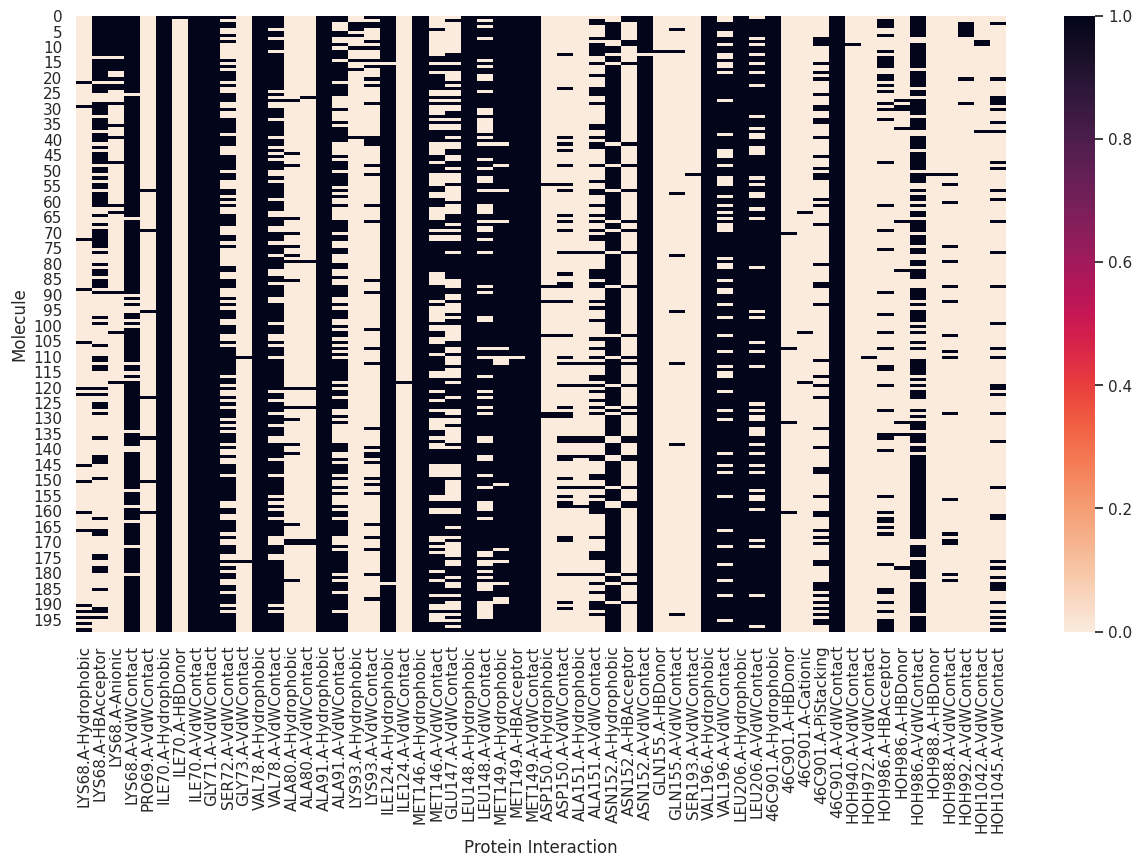

In [60]:
ifp_crem.drop(['ID'], axis=1, inplace=True)

visualize_fingerprint(ifp_crem)

<Axes: xlabel='Protein Interaction', ylabel='Molecule'>

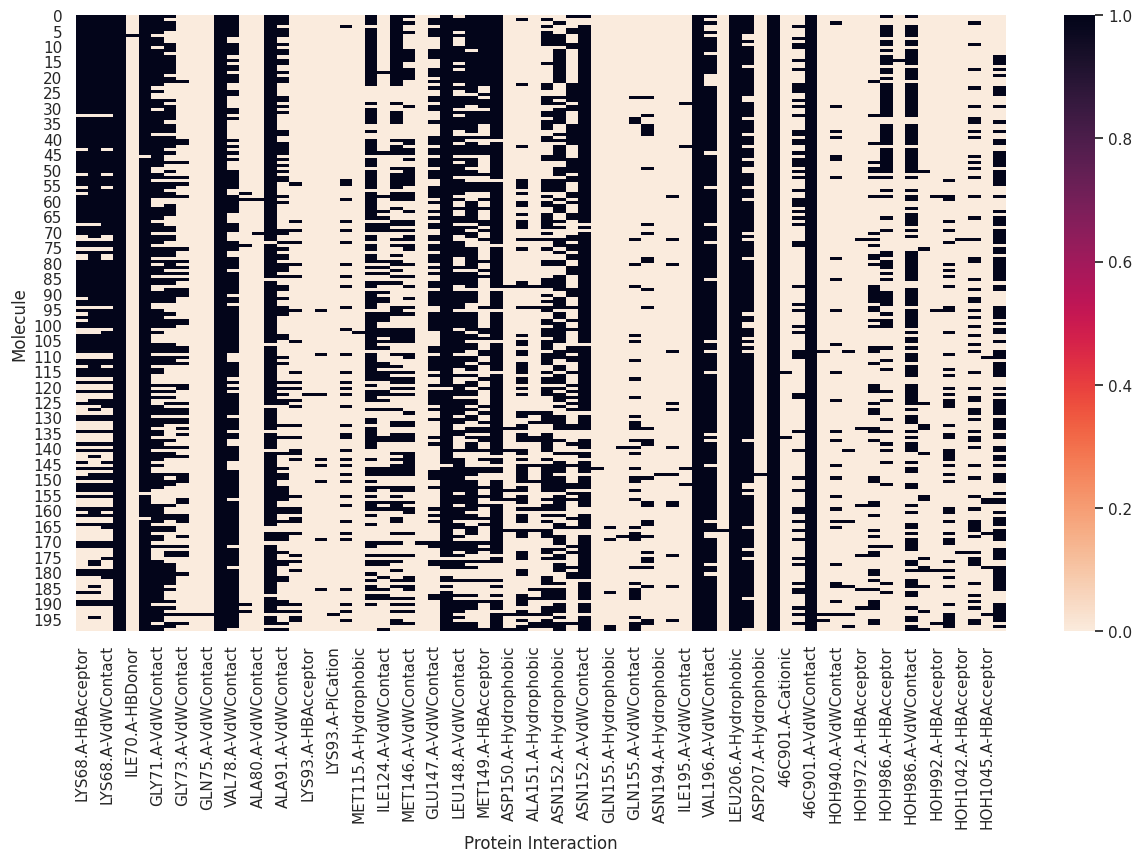

In [61]:
ifp_coati.drop(['ID'], axis=1, inplace=True)

visualize_fingerprint(ifp_coati)

<Axes: xlabel='Protein Interaction', ylabel='Molecule'>

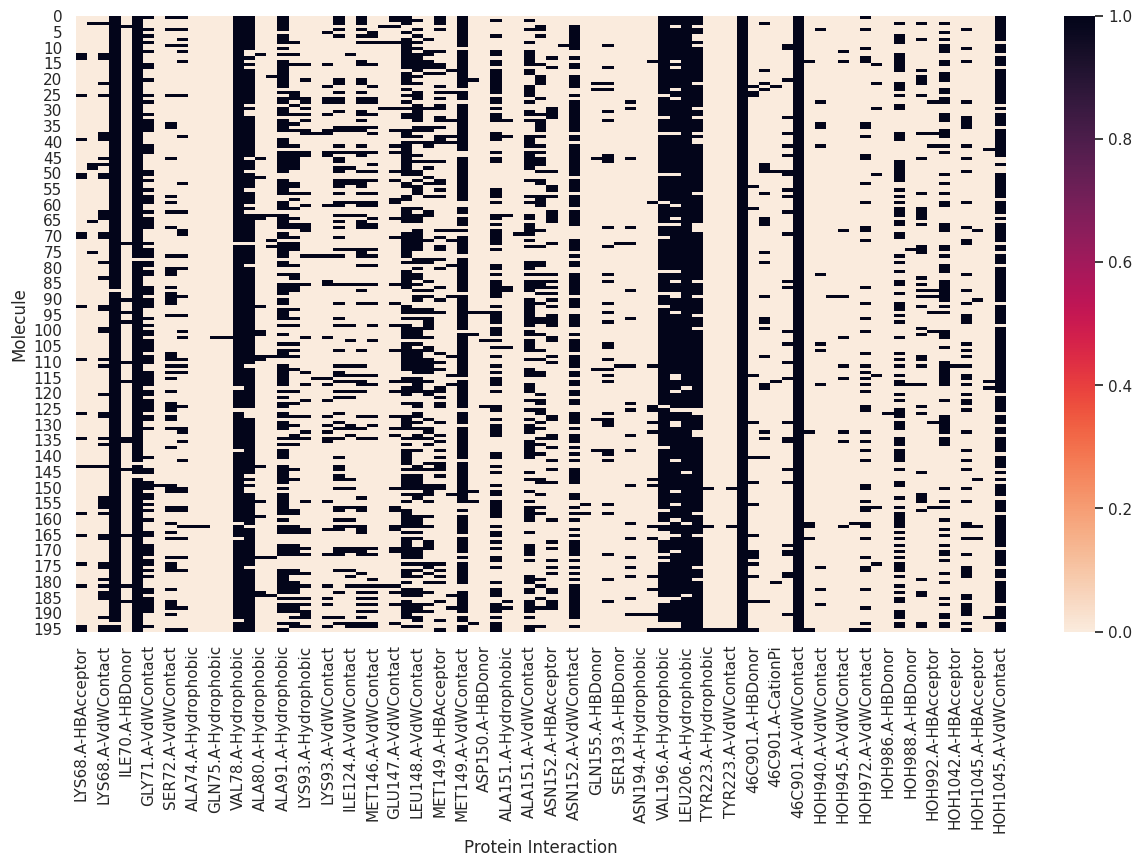

In [62]:
ifp_safe.drop(['ID'], axis=1, inplace=True)

visualize_fingerprint(ifp_safe)

<Axes: xlabel='Protein Interaction', ylabel='Molecule'>

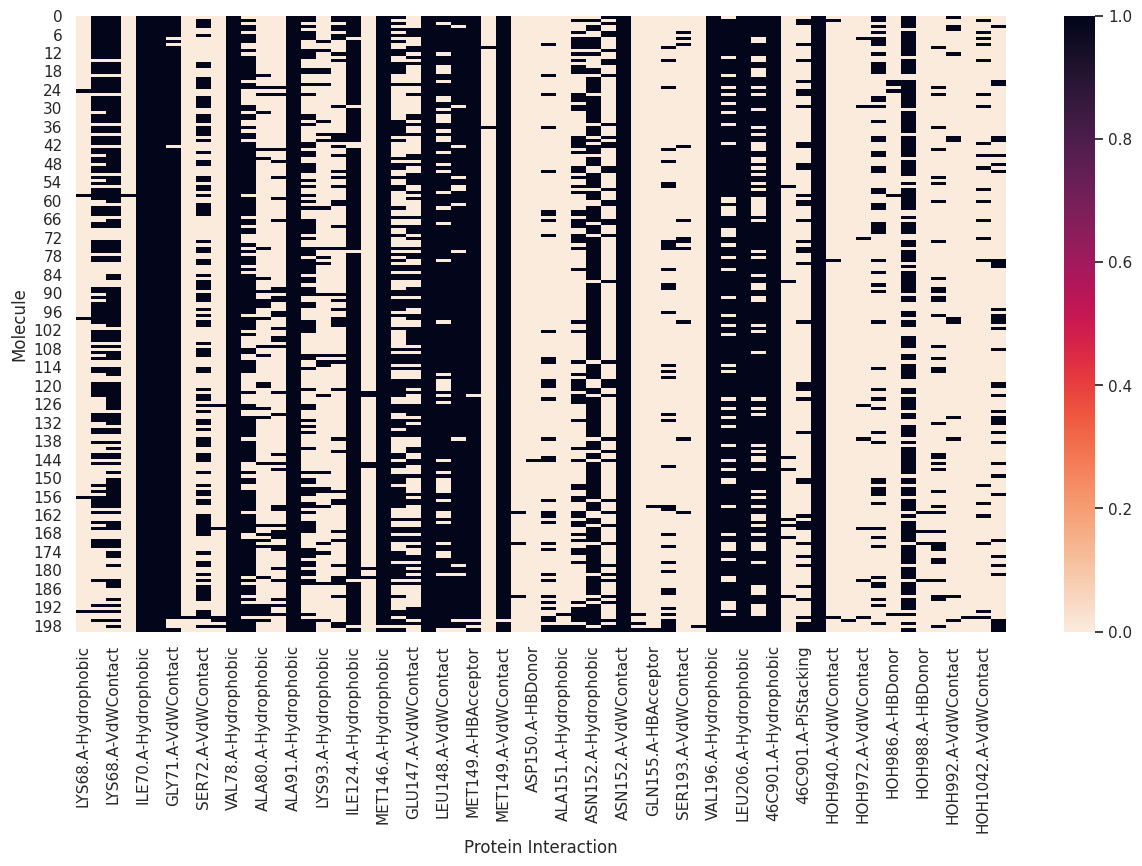

In [63]:
ifp_reinvent.drop(['ID'], axis=1, inplace=True)

visualize_fingerprint(ifp_reinvent)

In [64]:
len(ifp_safe.columns), len(ifp_coati.columns), len(ifp_crem.columns), len(ifp_reinvent.columns)

(83, 74, 58, 62)

### Visualizing Model Differences

In [65]:
df = df.merge(model_df[['SMILES', 'Model', 'Docking score', 'num_interactions', 'weighted_interactions', 'num_VdW', 'num_hydrophobic', 'num_HBAcceptor', 'num_ionic', 'rmsd']], left_on='smiles', right_on='SMILES', how='left')

In [66]:
df.drop(['SMILES'], axis=1, inplace=True)

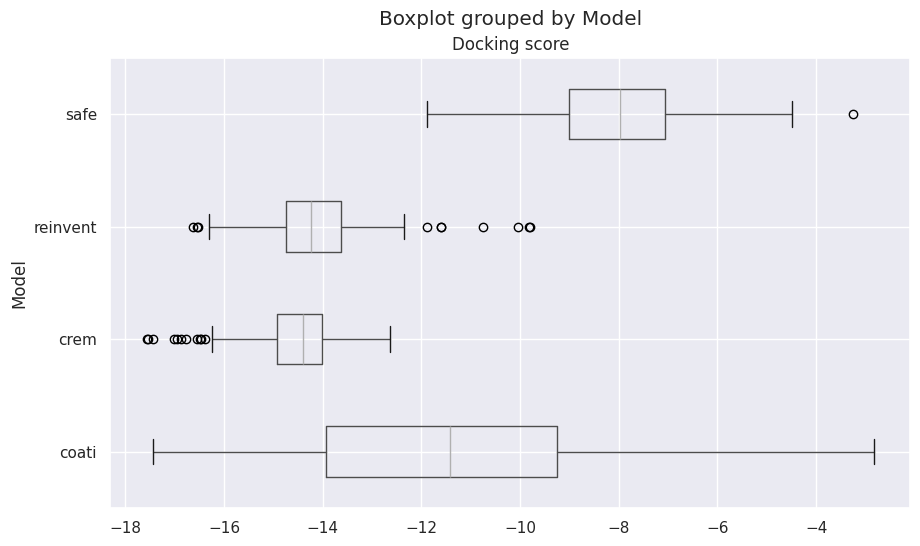

In [90]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['Docking score'], by='Model', ax=ax, **params)

ax = plt.gca()

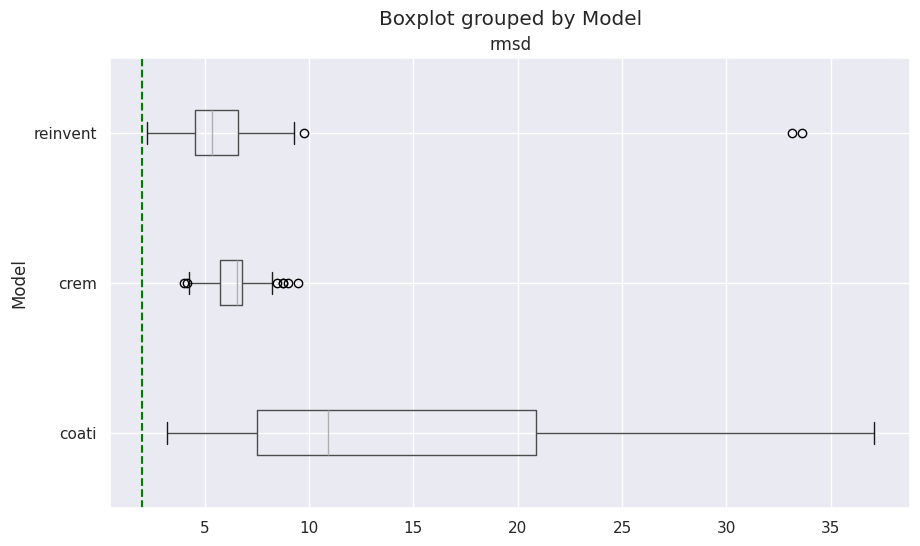

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['rmsd'], by='Model', ax=ax, **params)

ax = plt.gca()

plt.axvline(x=2, ls='dashed', c='green');

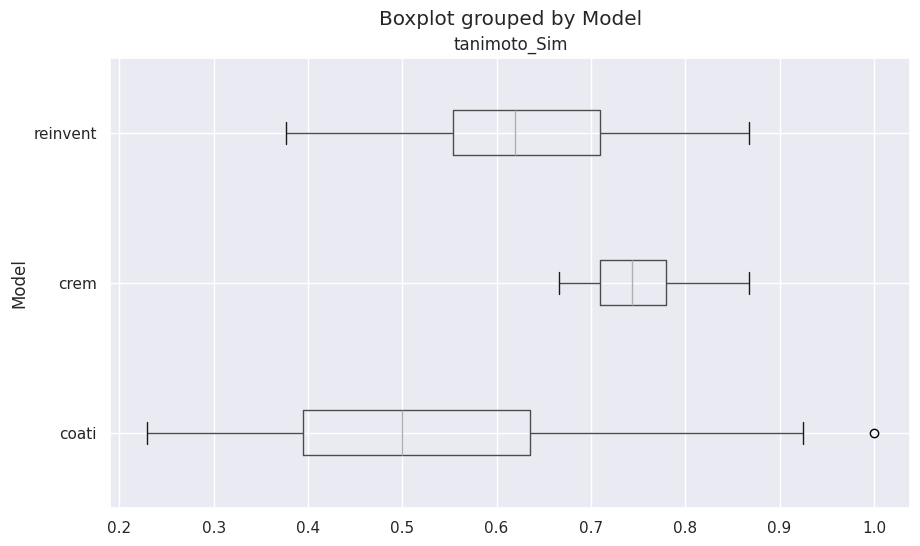

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['tanimoto_Sim'], by='Model', ax=ax, **params)

ax = plt.gca()

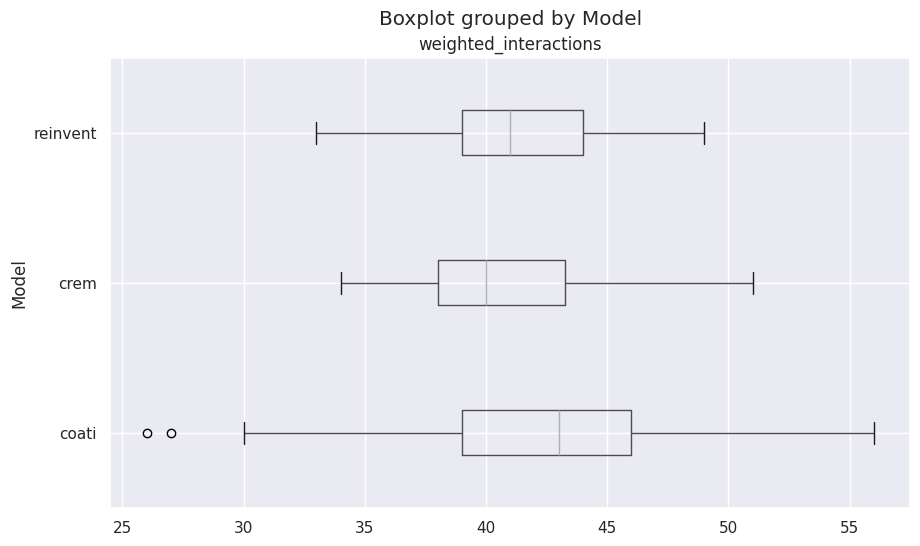

In [70]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['weighted_interactions'], by='Model', ax=ax, **params)

ax = plt.gca()

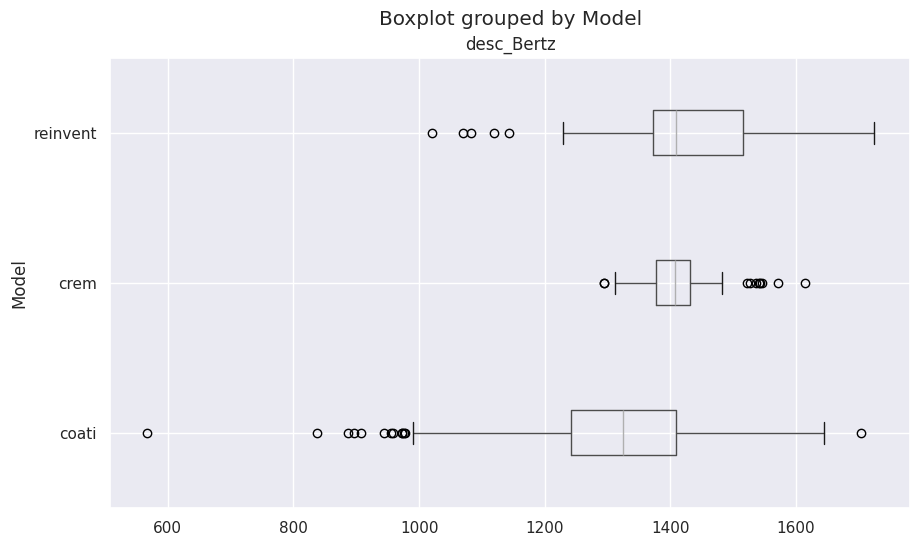

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['desc_Bertz'], by='Model', ax=ax, **params)

ax = plt.gca()

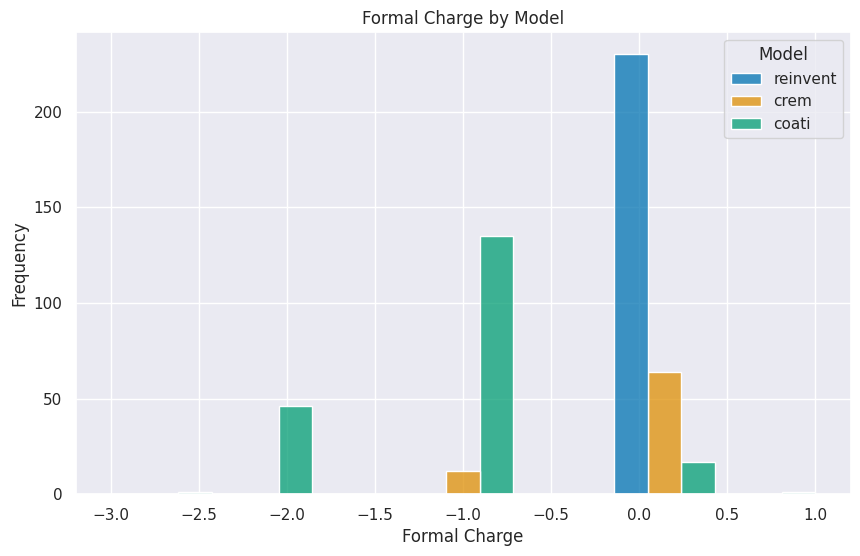

In [72]:
var = 'desc_FormalCharge'

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=var, hue='Model', multiple='dodge', palette='colorblind', bins=3, binwidth=.6,)

plt.xlabel('Formal Charge')
plt.ylabel('Frequency')
plt.title('Formal Charge by Model')

plt.show();

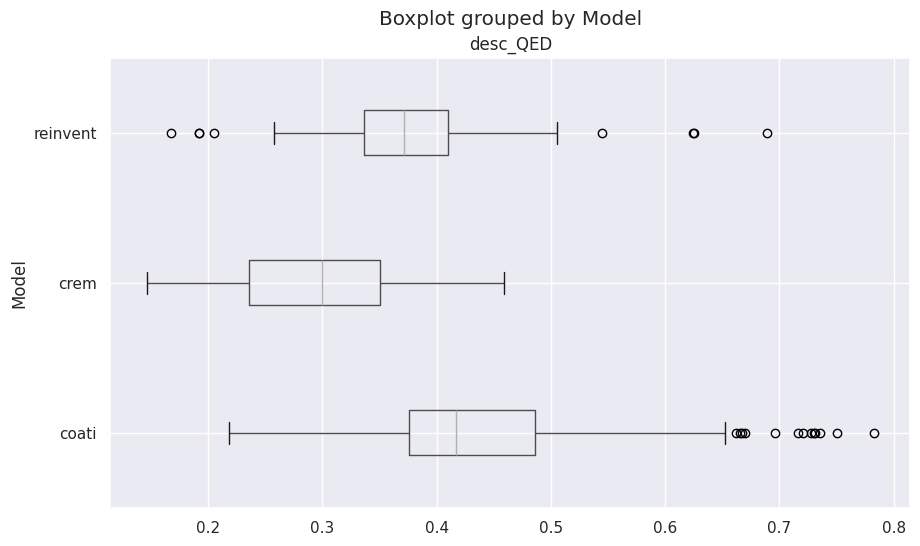

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['desc_QED'], by='Model', ax=ax, **params)

ax = plt.gca()

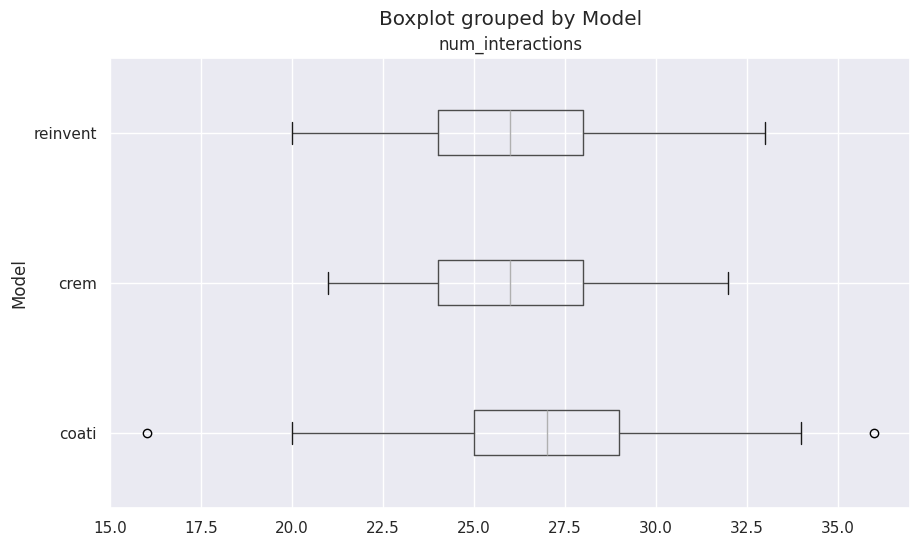

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['num_interactions'], by='Model', ax=ax, **params)

ax = plt.gca()

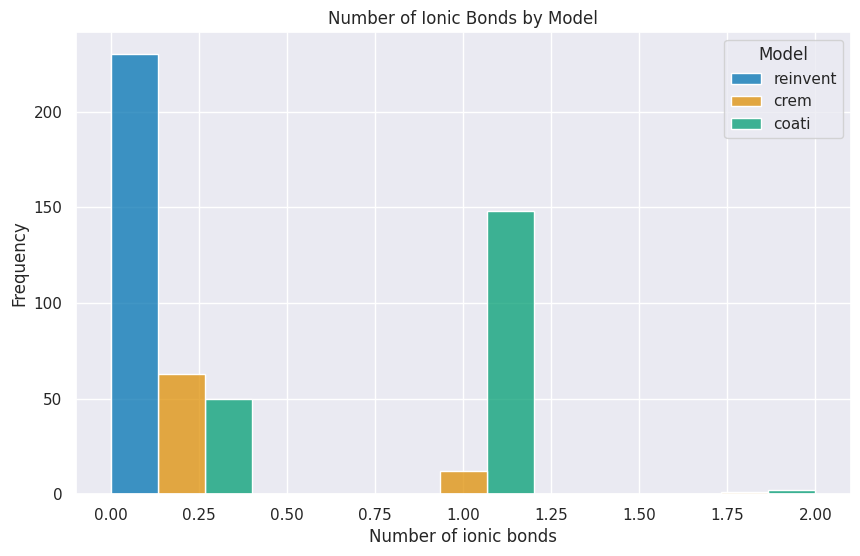

In [75]:
var = 'num_ionic'

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=var, hue='Model', multiple='dodge', palette='colorblind', bins=3, binwidth=.4,)

plt.xlabel('Number of ionic bonds')
plt.ylabel('Frequency')
plt.title('Number of Ionic Bonds by Model')

plt.show();

### Visualizing clusters w/ PCA and t-SNE

In [76]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_normalized)

In [77]:
pca = PCA(n_components=3, random_state=0)
pca_fps = pca.fit_transform(X_normalized)

In [78]:
var1, var2, var3 = pca.explained_variance_ratio_

In [79]:
var1, var2, var3

(0.4353874951979596, 0.11163599649294835, 0.08636358190590686)

In [80]:
model_df['PC1'], model_df['PC2'], model_df['PC3'] = pca_fps.T[0], pca_fps.T[1], pca_fps.T[2]

In [81]:
plot_df = model_df.sample(500)

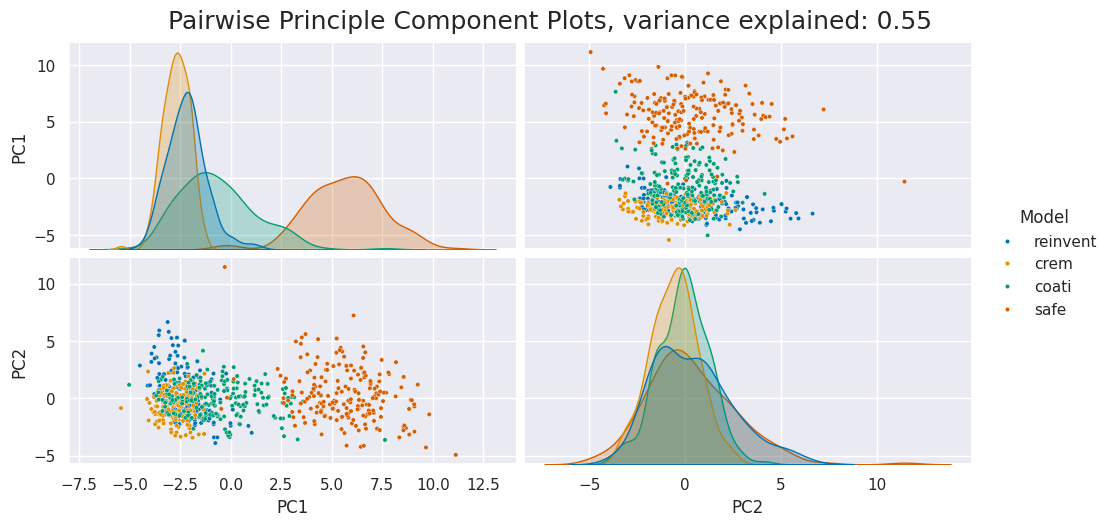

In [82]:
f = sns.pairplot(model_df,
                 hue='Model',
                 vars=['PC1', 'PC2'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

f.fig.suptitle(f'Pairwise Principle Component Plots, variance explained: {var1 + var2:.2f}', fontsize=18, y=1.04);

In [83]:
p = 50

pca_model = PCA(n_components=5, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=5000)
tsne_fps = tsne_model.fit_transform(pca_model.fit_transform(X))

In [84]:
model_df['TSNE1'], model_df['TSNE2'] = tsne_fps.T[0], tsne_fps.T[1]

In [85]:
plot_df = df.sample(n=500)

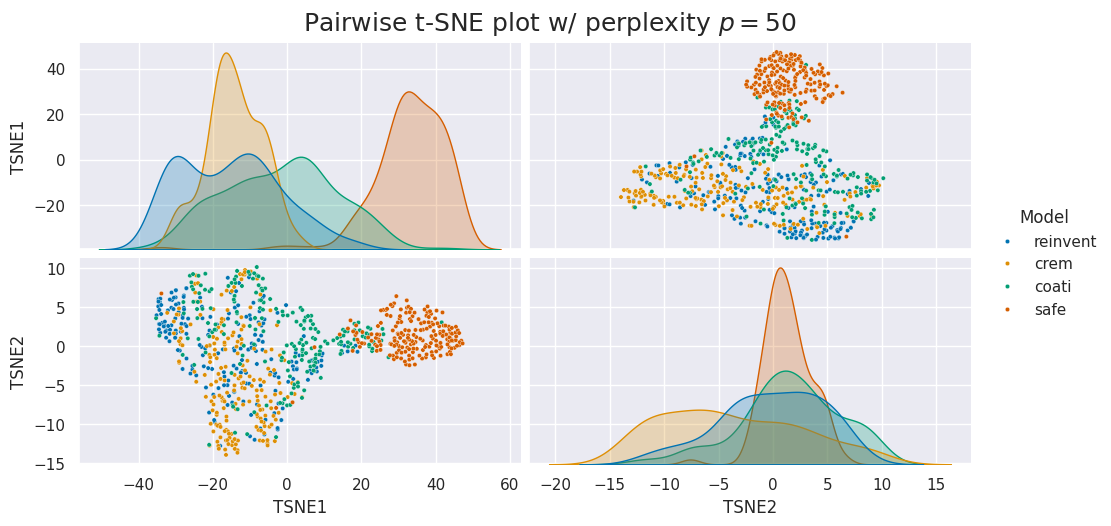

In [86]:
f = sns.pairplot(model_df,
                 hue='Model',
                 vars=['TSNE1', 'TSNE2'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

title = f'Pairwise t-SNE plot w/ perplexity $p={p}$'

f.fig.suptitle(title, fontsize=18, y=1.04);